In [82]:


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.optim as optim
import time



# 데이터 로드 및 전처리 함수
def load_and_preprocess_data(file_path):
    # 데이터 로드
    data = pd.read_csv(file_path)

  
    # 입력 데이터(X)와 타겟(y) 분리
    X = data.drop(["ID", "label"], axis=1)
    y = data["label"]

    # 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # 데이터 표준화
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test


# 데이터 로드 및 분리
X_train, X_test, y_train, y_test = load_and_preprocess_data("data/preprocessed.csv")

In [83]:
# PyTorch 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# TensorDataset과 DataLoader 생성 (배치 학습 적용)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [84]:
import torch
import torch.nn as nn

class ChurnPredictionModel(nn.Module):
    def __init__(self, input_dim):
        super(ChurnPredictionModel, self).__init__()
        
        # 은닉층과 배치 정규화, 드롭아웃 추가
        self.fc1 = nn.Linear(input_dim, 128)  # 첫 번째 은닉층
        self.bn1 = nn.BatchNorm1d(128)        # 첫 번째 배치 정규화
        self.fc2 = nn.Linear(128, 64)         # 두 번째 은닉층
        self.bn2 = nn.BatchNorm1d(64)         # 두 번째 배치 정규화
        self.fc3 = nn.Linear(64, 32)          # 세 번째 은닉층
        self.bn3 = nn.BatchNorm1d(32)         # 세 번째 배치 정규화
        self.fc4 = nn.Linear(32, 1)           # 출력층
        
        # 활성화 함수와 드롭아웃 설정
        self.relu = nn.ReLU()                 # 활성화 함수
        self.dropout = nn.Dropout(0.35)       # 드롭아웃 확률: 35%

    def forward(self, x):
        # 각 은닉층 통과 시 배치 정규화 및 드롭아웃 적용
        x = self.dropout(self.relu(self.bn1(self.fc1(x))))
        x = self.dropout(self.relu(self.bn2(self.fc2(x))))
        x = self.dropout(self.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))        # 이진 분류를 위한 sigmoid 활성화 함수
        return x


In [85]:
# 모델, 손실 함수, 옵티마이저 및 학습률 스케줄러 정의
input_dim = X_train.shape[1]
model = ChurnPredictionModel(input_dim)

criterion = nn.BCELoss()                     # 이진 분류에 적합한 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam 옵티마이저

# 학습률 조정 스케줄러: CosineAnnealingWarmRestarts를 사용하여 학습률을 주기적으로 리셋
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1, eta_min=0.00001)


In [86]:
# 초기화
num_epochs = 100
best_score = float('inf')  # 성능 개선 기준 초기값
patience = 20               # 조기 종료를 위한 patience 값
trigger_count = 0          # 개선이 없을 때 증가하는 카운트
save_path = "best_churn_model.pth"  # 최적 모델 저장 경로
s = time.time()  # 학습 시작 시간 기록


# 손실과 정확도 기록용 리스트 초기화
train_losses = []
train_accuracies = []
valid_losses = []
valid_acces = []
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_predictions = 0  # 정확도 계산을 위한 초기화
    total_predictions = 0    # 총 예측 개수 초기화
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        
        # 손실 계산 및 역전파
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # 정확도 계산
        predictions = (outputs > 0.5).float()  # 0.5를 기준으로 이진 분류
        correct_predictions += (predictions == y_batch).sum().item()
        total_predictions += y_batch.size(0)

    # 에포크 평균 손실 및 정확도 계산
    avg_loss = train_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions  # 정확도 계산

       # 손실 및 정확도 기록
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

    model.eval()
    valid_loss = valid_acc = 0.0
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            pred_test = model(X_test).squeeze() # positive일 확률
            valid_loss += criterion(pred_test, y_test).item()
            #  이진 분류에서 accuracy
            valid_acc += torch.sum((pred_test > 0.5).type(torch.int32) == y_test).item()
        valid_loss /= len(test_loader)
        valid_acc /= len(test_loader.dataset)
        valid_losses.append(valid_loss)
        valid_acces.append(valid_acc)

    
    # Best Score 업데이트 및 조기 종료 체크
    if valid_loss < best_score:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss Improved from {best_score:.4f} to {valid_loss:.4f}. Saving Model.")
        best_score = valid_loss
        torch.save(model.state_dict(), save_path)
        trigger_count = 0  # 성능 개선 시 초기화
    else:
        trigger_count += 1
        if trigger_count >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement for {patience} epochs.")
            break

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_acc: {valid_acc:.4f}")

e = time.time()
training_time = e - s
print(f"\nTotal Training Time: {training_time:.2f} seconds")


Epoch [1/100], Loss Improved from inf to 0.4350. Saving Model.
Epoch [1/100], Loss: 0.4879, Accuracy: 0.7781, valid_loss: 0.4350, valid_acc: 0.8182
Epoch [2/100], Loss Improved from 0.4350 to 0.4271. Saving Model.
Epoch [2/100], Loss: 0.4270, Accuracy: 0.8199, valid_loss: 0.4271, valid_acc: 0.8157
Epoch [3/100], Loss Improved from 0.4271 to 0.4254. Saving Model.
Epoch [3/100], Loss: 0.4191, Accuracy: 0.8225, valid_loss: 0.4254, valid_acc: 0.8185
Epoch [4/100], Loss: 0.4189, Accuracy: 0.8245, valid_loss: 0.4256, valid_acc: 0.8175
Epoch [5/100], Loss Improved from 0.4254 to 0.4247. Saving Model.
Epoch [5/100], Loss: 0.4168, Accuracy: 0.8241, valid_loss: 0.4247, valid_acc: 0.8178
Epoch [6/100], Loss Improved from 0.4247 to 0.4225. Saving Model.
Epoch [6/100], Loss: 0.4147, Accuracy: 0.8249, valid_loss: 0.4225, valid_acc: 0.8178
Epoch [7/100], Loss: 0.4146, Accuracy: 0.8245, valid_loss: 0.4231, valid_acc: 0.8157
Epoch [8/100], Loss Improved from 0.4225 to 0.4206. Saving Model.
Epoch [8/100

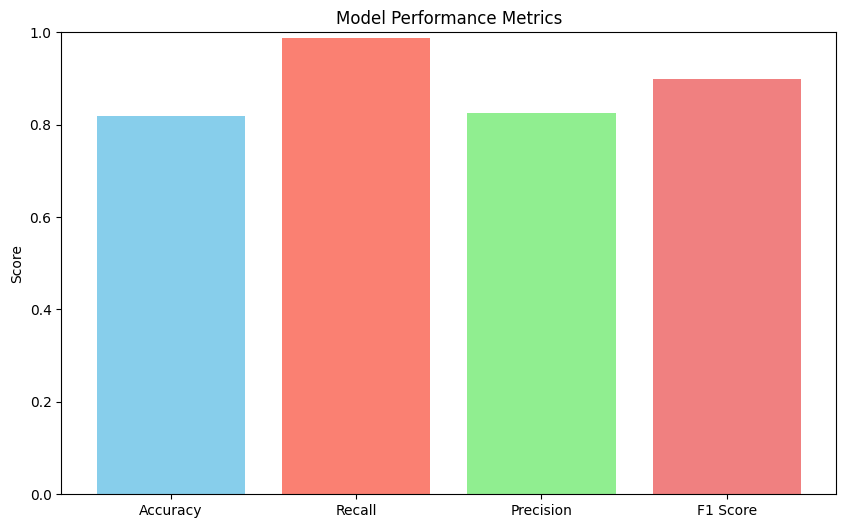

In [53]:
# 모델 평가
model.eval()
y_pred_list = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        y_pred = model(X_batch).squeeze()
        y_pred = y_pred.round()  # 0.5를 기준으로 반올림하여 이진 분류
        y_pred_list.append(y_pred.numpy())
y_pred_list = np.concatenate(y_pred_list)

# 성능 평가 지표 계산
accuracy = accuracy_score(y_test, y_pred_list)
recall = recall_score(y_test, y_pred_list)
precision = precision_score(y_test, y_pred_list)
f1 = f1_score(y_test, y_pred_list)

# 정확도, 재현율, 정밀도, F1 점수 시각화
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
values = [accuracy, recall, precision, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()


In [54]:
"""
데이터 로드 및 전처리: 데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.

모델 정의:

드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.
ReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.
옵티마이저 및 스케줄러 설정:

Adam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.
CosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.
학습 과정:

optimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.
매 에포크마다 학습 손실과 정확도를 기록합니다.
scheduler.step()을 통해 매 에포크마다 학습률을 조정하여 **과적합 방지
"""

'\n데이터 로드 및 전처리: 데이터를 불러오고, 결측치를 제거한 후 타겟 값을 인코딩하고 표준화하여 학습 및 평가 데이터셋으로 분리합니다.\n\n모델 정의:\n\n드롭아웃을 각 은닉층에 추가하여 과적합을 방지하고, 모델의 일반화 성능을 높입니다.\nReLU 활성화 함수로 비선형성을 추가하여 복잡한 패턴을 학습할 수 있게 합니다.\n옵티마이저 및 스케줄러 설정:\n\nAdam 옵티마이저로 학습 속도를 개선하고, 자동으로 학습률을 조절합니다.\nCosineAnnealingWarmRestarts를 사용하여 학습률을 점진적으로 감소시키면서 주기적으로 리셋하여, 최적점을 찾기 쉽도록 합니다.\n학습 과정:\n\noptimizer.zero_grad()로 각 배치마다 그래디언트를 초기화하고, loss.backward()로 역전파를 수행한 후 optimizer.step()으로 모델 파라미터를 업데이트합니다.\n매 에포크마다 학습 손실과 정확도를 기록합니다.\nscheduler.step()을 통해 매 에포크마다 학습률을 조정하여 **과적합 방지\n'

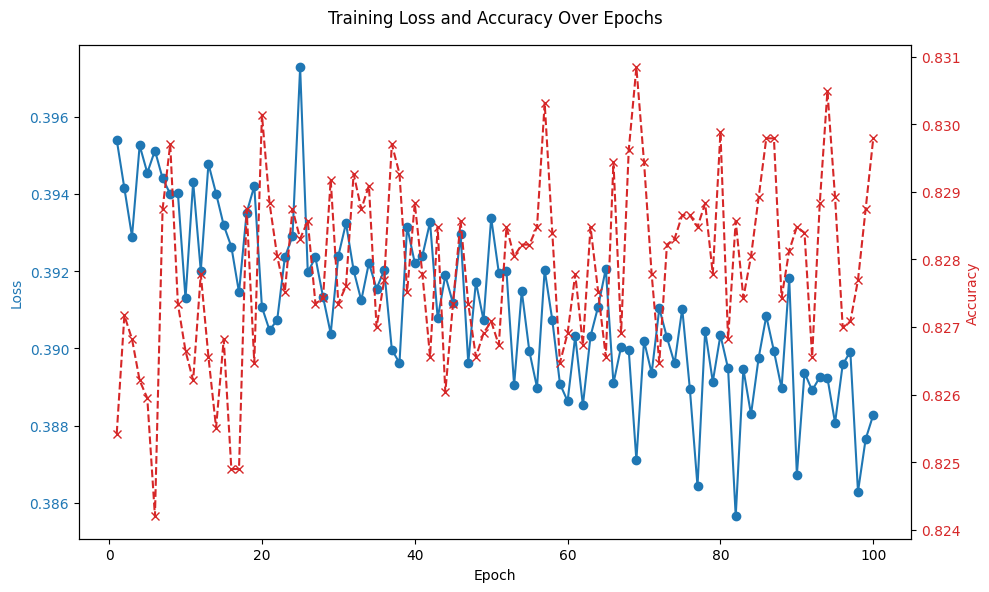

In [55]:
# 이중 y축 그래프: 학습 손실 및 정확도 변화 추세
fig, ax1 = plt.subplots(figsize=(10, 6))

# 손실 값 (왼쪽 y축)
color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1, len(train_losses) + 1), train_losses, color=color, marker='o', label='Train Loss')
ax1.tick_params(axis='y', labelcolor=color)

# 정확도 값 (오른쪽 y축)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, color=color, marker='x', linestyle='--', label='Train Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.suptitle('Training Loss and Accuracy Over Epochs')
fig.tight_layout()
plt.show()



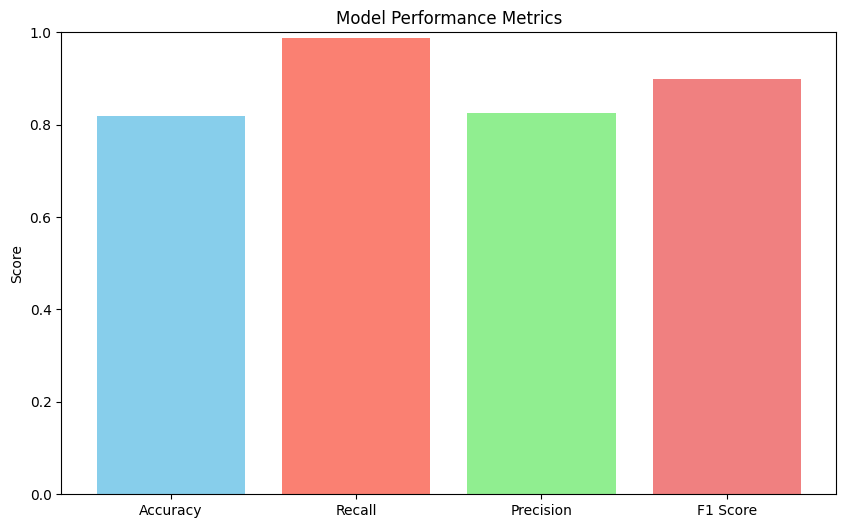

In [56]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# 성능 지표 계산
accuracy = accuracy_score(y_test, y_pred_list)
recall = recall_score(y_test, y_pred_list)
precision = precision_score(y_test, y_pred_list)
f1 = f1_score(y_test, y_pred_list)

# 막대 그래프 그리기
metrics = ['Accuracy', 'Recall', 'Precision', 'F1 Score']
values = [accuracy, recall, precision, f1]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['skyblue', 'salmon', 'lightgreen', 'lightcoral'])
plt.ylim(0, 1)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()


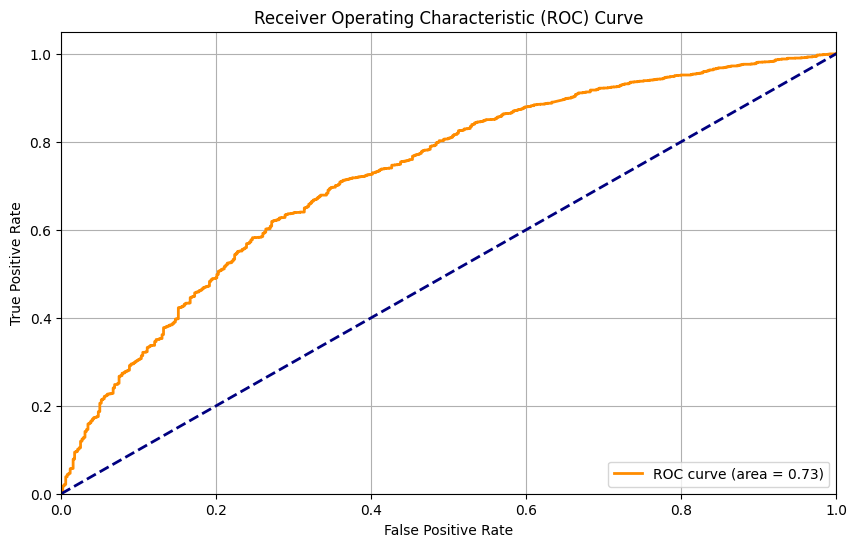

In [57]:
# 모델 평가
model.eval()
y_pred_list = []
y_prob_list = []  # 예측 확률을 저장할 리스트 추가

with torch.no_grad():
    for X_batch, _ in test_loader:
        # 예측 확률 계산
        y_prob = model(X_batch).squeeze()
        y_pred = y_prob.round()  # 0.5 기준으로 반올림하여 이진 분류

        # 예측 클래스와 예측 확률 저장
        y_pred_list.extend(y_pred.numpy())
        y_prob_list.extend(y_prob.numpy())  # 예측 확률 추가

# ROC 곡선 및 AUC 계산
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob_list)
roc_auc = auc(fpr, tpr)

# ROC 곡선 그리기
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


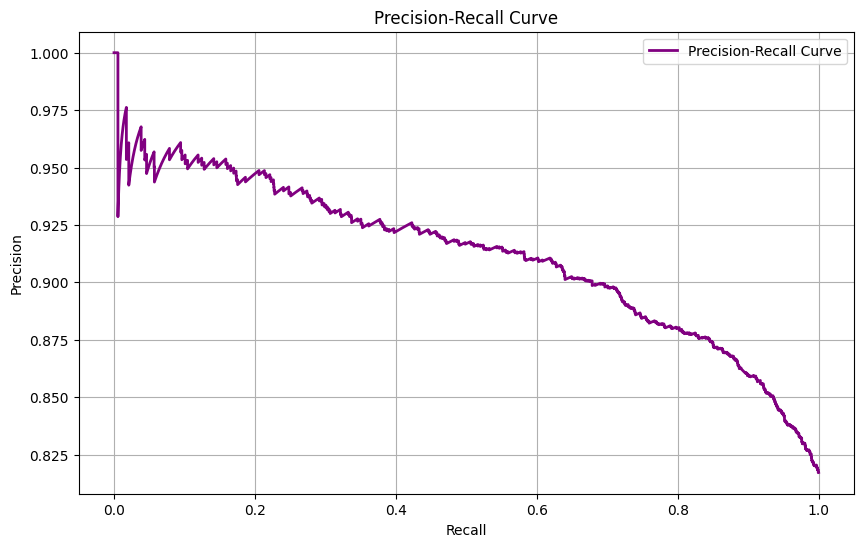

In [58]:
from sklearn.metrics import precision_recall_curve

# Precision-Recall 곡선
precision, recall, _ = precision_recall_curve(y_test, y_prob_list)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', lw=2, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid()
plt.show()


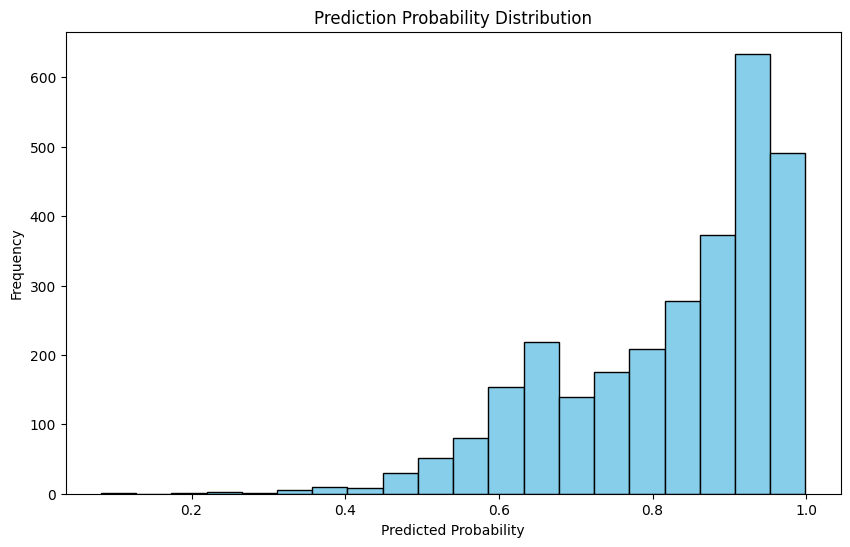

In [59]:
# 예측 확률 히스토그램
plt.figure(figsize=(10, 6))
plt.hist(y_prob_list, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.show()


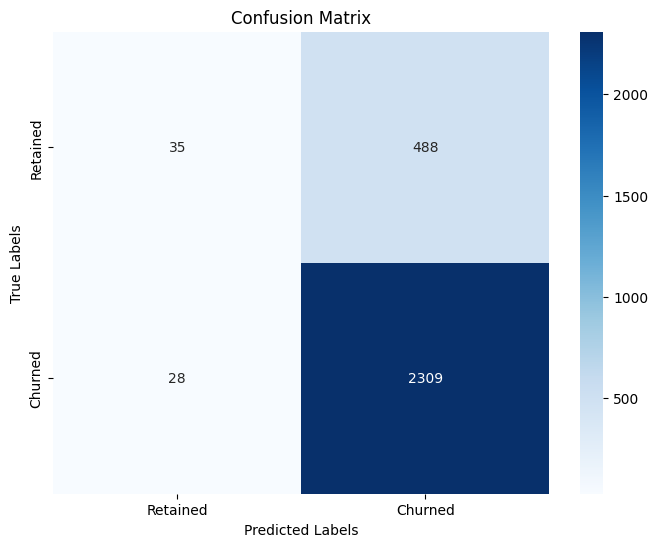

In [60]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred_list)

# 히트맵으로 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Retained', 'Churned'], yticklabels=['Retained', 'Churned'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


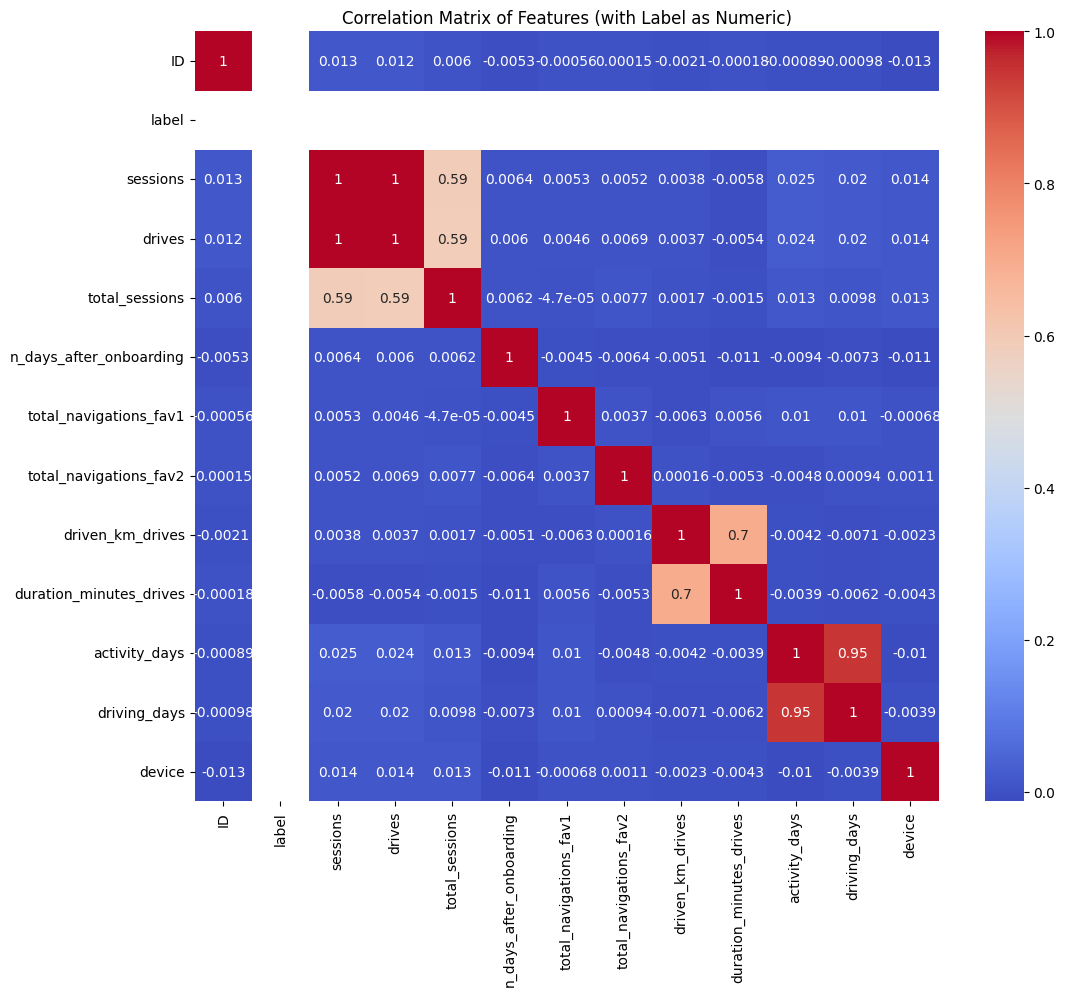

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("preprocessed.csv")  # 파일 경로에 맞게 수정

# label 칼럼 변환: retained -> 0, churned -> 1
df['label'] = df['label'].map({'retained': 0, 'churned': 1})

# 숫자형 데이터만 선택 (변환된 label 포함)
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# 상관 행렬 시각화
plt.figure(figsize=(12, 10))
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features (with Label as Numeric)')
plt.show()



In [62]:
"""
sessions
사용자가 한 달 동안 앱을 연 횟수입니다. 일반적으로 세션 수가 적을수록 이탈률이 높게 나타날 가능성이 큽니다. 세션 수가 늘어나면 앱에 대한 관심과 사용 필요도가 높다는 뜻이므로, 이탈률이 낮아지는 경향이 있습니다.

drives
한 달 동안 최소 1km 이상 주행한 횟수를 나타냅니다. 드라이브 횟수가 적은 사용자는 앱을 자주 사용하지 않으므로 이탈률이 높아질 수 있습니다. 반면, 드라이브 횟수가 증가하면 앱 사용도가 높아지며, 이탈률은 낮아지는 경향이 보일 수 있습니다.

total_sessions
사용자가 가입 이후 실행한 총 세션 수입니다. 총 세션 수가 많을수록 사용자가 앱을 자주 사용했음을 의미하며, 이탈률이 낮아질 가능성이 큽니다.

n_days_after_onboarding
가입 이후 지난 일 수를 나타냅니다. 이 값이 작을수록 신규 사용자일 가능성이 높습니다. 일반적으로 신규 사용자는 앱 사용 초기의 경험이 만족스럽지 않으면 쉽게 이탈할 수 있으므로, 이 값이 작을수록 이탈률이 높을 수 있습니다.

total_navigations_fav1 및 total_navigations_fav2
사용자가 즐겨찾는 장소 1과 2로의 총 네비게이션 횟수입니다. 이 값이 높을수록 사용자가 특정 장소를 자주 찾는 경향을 보이며, 앱의 필요성이 커지므로 이탈률이 낮아질 가능성이 있습니다.

driven_km_drives
한 달 동안 총 주행 거리(km)입니다. 주행 거리가 길수록 사용자가 운전에 더 의존하며, 네비게이션이 필요할 가능성이 커져 이탈률이 낮아질 수 있습니다.

duration_minutes_drives
한 달 동안 총 운전 시간(분)입니다. 운전 시간이 길수록 사용자가 앱을 자주 사용하며 이탈률이 낮아질 가능성이 큽니다.

activity_days
사용자가 한 달 동안 앱을 실행한 총 일 수입니다. 이 값이 높을수록 앱 사용 빈도가 높아져 이탈률이 낮아질 수 있습니다.

driving_days
한 달 동안 최소 1km 이상 운전한 날 수입니다. 운전한 날이 많을수록 앱 사용 필요성이 커지며, 이탈률은 낮아지는 경향을 보일 수 있습니다.
"""

'\nsessions\n사용자가 한 달 동안 앱을 연 횟수입니다. 일반적으로 세션 수가 적을수록 이탈률이 높게 나타날 가능성이 큽니다. 세션 수가 늘어나면 앱에 대한 관심과 사용 필요도가 높다는 뜻이므로, 이탈률이 낮아지는 경향이 있습니다.\n\ndrives\n한 달 동안 최소 1km 이상 주행한 횟수를 나타냅니다. 드라이브 횟수가 적은 사용자는 앱을 자주 사용하지 않으므로 이탈률이 높아질 수 있습니다. 반면, 드라이브 횟수가 증가하면 앱 사용도가 높아지며, 이탈률은 낮아지는 경향이 보일 수 있습니다.\n\ntotal_sessions\n사용자가 가입 이후 실행한 총 세션 수입니다. 총 세션 수가 많을수록 사용자가 앱을 자주 사용했음을 의미하며, 이탈률이 낮아질 가능성이 큽니다.\n\nn_days_after_onboarding\n가입 이후 지난 일 수를 나타냅니다. 이 값이 작을수록 신규 사용자일 가능성이 높습니다. 일반적으로 신규 사용자는 앱 사용 초기의 경험이 만족스럽지 않으면 쉽게 이탈할 수 있으므로, 이 값이 작을수록 이탈률이 높을 수 있습니다.\n\ntotal_navigations_fav1 및 total_navigations_fav2\n사용자가 즐겨찾는 장소 1과 2로의 총 네비게이션 횟수입니다. 이 값이 높을수록 사용자가 특정 장소를 자주 찾는 경향을 보이며, 앱의 필요성이 커지므로 이탈률이 낮아질 가능성이 있습니다.\n\ndriven_km_drives\n한 달 동안 총 주행 거리(km)입니다. 주행 거리가 길수록 사용자가 운전에 더 의존하며, 네비게이션이 필요할 가능성이 커져 이탈률이 낮아질 수 있습니다.\n\nduration_minutes_drives\n한 달 동안 총 운전 시간(분)입니다. 운전 시간이 길수록 사용자가 앱을 자주 사용하며 이탈률이 낮아질 가능성이 큽니다.\n\nactivity_days\n사용자가 한 달 동안 앱을 실행한 총 일 수입니다. 이 값이 높을수록 앱 사용 빈도가 높아져 이탈률이 낮아질 수 있습니다.\n\ndriving_d